In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import scanpy as sc
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time

# Evaluation metrics
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

# Import SpaLP modules    Python package: https://github.com/dbjzs/SpaLP
from SpaLP.LP import SpatialLocalPooling
from SpaLP.utils import set_seed, prepare_inputs
# Set random seed
set_seed(7)

#Check the GPU memory and CPU memory
import memory_profiler  # pip install memory_profiler
import torch
import gc

# Check device
import cpuinfo   # pip install py-cpuinfo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
info = cpuinfo.get_cpu_info()
print("CPU:", info['brand_raw'])

Using device: cuda
GPU: NVIDIA A800-SXM4-80GB
CPU: Intel(R) Xeon(R) Platinum 8462Y+


In [2]:
#Check the GPU memory and CPU memory
from memory_profiler import memory_usage
def measure_resources(func):
    def wrapper(*args, **kwargs):
        gc.collect()
        torch.cuda.synchronize()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()
        
        before = memory_usage(-1, interval=0.1, timeout=1)[0]
        mem_peak, result = memory_usage((func, args, kwargs),max_usage=True,retval=True)
        print(f"CPU peak memory: {(mem_peak - before)/1024:.2f} GB")
        
        torch.cuda.synchronize()
        gpu_peak = torch.cuda.max_memory_allocated() / 1024**3
        print(f"GPU peak memory: {gpu_peak:.2f} GB")
        return result
    return wrapper

In [3]:
def train_spalp(graph, in_channels, hidden_dim, epochs, lr, device,seed):
    """Train SpaLP model and return embeddings."""
    from tqdm.auto import tqdm
    set_seed(seed)
    pbar = tqdm(range(epochs), desc="Training",ncols=200)
    model = SpatialLocalPooling(in_channels, hidden_dim).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.train()
    losses = []
    
    for epoch in pbar:
        start_time = time.time()
        model.train()
        optimizer.zero_grad()
        reconstructed,embedding = model(graph.features, graph.neighbor_idx)
        loss = criterion(reconstructed, graph.features)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        elapsed = time.time() - start_time
        pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})
    
    # Get final embeddings
    model.eval()
    with torch.no_grad():
        reconstructed,embedding = model(graph.features, graph.neighbor_idx)
        reconstructed = reconstructed.cpu().numpy()
        embedding=embedding.cpu().numpy()
    return embedding, losses

In [9]:
def evaluate_clustering(adata, pred_key=None, true_key=None):
    metrics = {}
    true_labels = np.array(adata.obs[true_key])
    cluster_labels = np.array(adata.obs[pred_key])
    
    metrics['ARI'] = adjusted_rand_score(true_labels, cluster_labels)
    metrics['NMI'] = normalized_mutual_info_score(true_labels, cluster_labels)
    metrics['AMI'] = adjusted_mutual_info_score(true_labels, cluster_labels)
    metrics['FMI'] = fowlkes_mallows_score(true_labels, cluster_labels)
    metrics['V-Measure'] = v_measure_score(true_labels, cluster_labels)
    metrics['Homogeneity'] = homogeneity_score(true_labels, cluster_labels)
    
    print(f"  ARI: {metrics['ARI']:.4f}")
    print(f"  NMI: {metrics['NMI']:.4f}")
    print(f"  AMI: {metrics['AMI']:.4f}")
    print(f"  FMI: {metrics['FMI']:.4f}")
    print(f"  V-Measure: {metrics['V-Measure']:.4f}")
    print(f"  Homogeneity: {metrics['Homogeneity']:.4f}")
    
    return metrics

# BALBc-1 CODEX Mouse spleen data

In [4]:
adata=sc.read_h5ad('/home/dbj/SpaLA/Batch/CODEX/BALBc-1.h5ad')
adata.var_names_make_unique()
print(f"Shape: {adata.shape[0]:,} cells x {adata.shape[1]:,} proteins")
print(f"obsm keys: {list(adata.obsm.keys())}")

Shape: 82,251 cells x 30 proteins
obsm keys: ['spatial']


In [5]:
# Preprocessing standardization  *******
start_time = time.time()
sc.pp.scale(adata)
adata.obsm['feat']=adata.X
prep_time = time.time() - start_time

print(f"Spatial coords shape: {adata.obsm['spatial'].shape}")
print(f"Preprocessing standardization: {prep_time:.2f}s")

Spatial coords shape: (82251, 2)
Preprocessing standardization: 0.02s


In [6]:
# Set the hyperparameters  k=50
k=50
in_channels = adata.obsm['feat'].shape[1]
lr=0.001
epochs = 200
hidden_dim=32
print(f"Feature dimensions: {in_channels}")

Feature dimensions: 30


In [7]:
# Build neighbor graph  k=50
start_time = time.time()
graph = prepare_inputs(adata, k=k,device=device)
prep_time = time.time() - start_time
print(f"Graph preparation: {prep_time:.2f}s")

Graph preparation: 0.20s


In [8]:
%%time
#runtime /GPU peak memory/CPU peak memory
start_time = time.time()
@measure_resources
def run_train():
    return train_spalp(graph, in_channels, hidden_dim, epochs, lr, device, seed=7)#The default random seed for the SpaLP algorithm is 7.
embedding, losses = run_train()
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f}s")

# Store embeddings
adata.obsm['SpaLP'] = embedding

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:13<00:00, 14.60it/s, Epoch=199, Loss=0.8706]


CPU peak memory: 0.46 GB
GPU peak memory: 7.79 GB
Training time: 14.87s
CPU times: user 13.5 s, sys: 394 ms, total: 13.9 s
Wall time: 14.9 s


In [23]:
%%time
# Clustering and UMAP
start_time = time.time()
sc.pp.neighbors(adata, use_rep="SpaLP")
sc.tl.leiden(adata, resolution=0.2, random_state=2024, key_added="SpaLP")#The clustering results save in adata.obs['SpaLP']
elapsed = time.time() - start_time
print(f"Leiden time: {int(elapsed//60)}min {elapsed%60:.2f}s")

t0 = time.time()
sc.tl.umap(adata)
elapsed = time.time() - t0
print(f"UMAP time: {int(elapsed//60)}min {elapsed%60:.2f}s")
print(f"Found {len(adata.obs['SpaLP'].unique())} clusters")

Leiden time: 1min 30.35s
UMAP time: 0min 32.06s
Found 38 clusters
CPU times: user 4min 40s, sys: 3min 44s, total: 8min 25s
Wall time: 2min 2s


In [18]:
%%time
# KMeans time
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=2024) 
labels = kmeans.fit_predict(adata.obsm['SpaLP'])
adata.obs['Kmeans_SpaLP']=labels.astype(str)  #The clustering results save in adata.obs['Kmeans_SpaLP']

CPU times: user 5.72 s, sys: 4.29 s, total: 10 s
Wall time: 142 ms


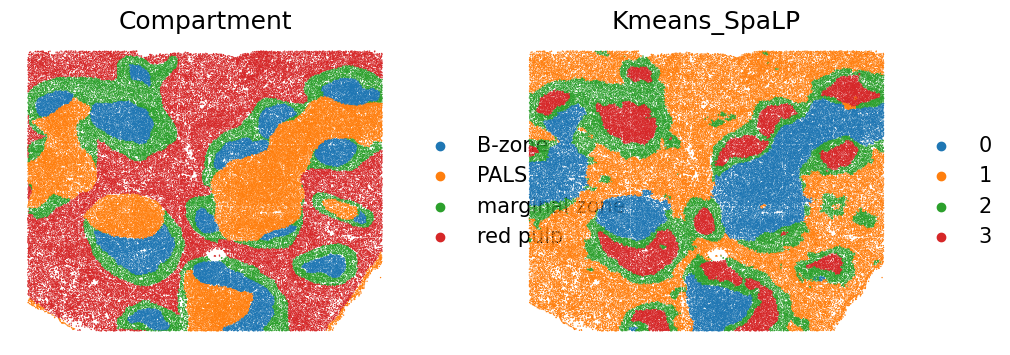

In [20]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata,basis='spatial',color=['Compartment','Kmeans_SpaLP'],frameon=False,size=4)

In [22]:
metrics = evaluate_clustering(adata, pred_key='Kmeans_SpaLP', true_key='Compartment')

  ARI: 0.6532
  NMI: 0.6173
  AMI: 0.6173
  FMI: 0.7490
  V-Measure: 0.6173
  Homogeneity: 0.6150


In [25]:
adata.write_h5ad('/home/dbj/SpaLP/gittest/repoduced/result/Ex3BALBc-1.h5ad',compression='gzip')#Save the embedding for rapid single-cell (GPU-scanpy) analysis

# BALBc-2 CODEX Mouse spleen data

In [26]:
adata=sc.read_h5ad('/home/dbj/SpaLA/Batch/CODEX/BALBc-2.h5ad')
adata.var_names_make_unique()
print(f"Shape: {adata.shape[0]:,} cells x {adata.shape[1]:,} proteins")
print(f"obsm keys: {list(adata.obsm.keys())}")

Shape: 81,346 cells x 30 proteins
obsm keys: ['spatial']


In [27]:
# Preprocessing standardization  *******
start_time = time.time()
sc.pp.scale(adata)
adata.obsm['feat']=adata.X
prep_time = time.time() - start_time

print(f"Spatial coords shape: {adata.obsm['spatial'].shape}")
print(f"Preprocessing standardization: {prep_time:.2f}s")

Spatial coords shape: (81346, 2)
Preprocessing standardization: 0.02s


In [28]:
# Set the hyperparameters  k=50
k=50
in_channels = adata.obsm['feat'].shape[1]
lr=0.001
epochs = 200
hidden_dim=32
print(f"Feature dimensions: {in_channels}")

Feature dimensions: 30


In [29]:
# Build neighbor graph  k=50
start_time = time.time()
graph = prepare_inputs(adata, k=k,device=device)
prep_time = time.time() - start_time
print(f"Graph preparation: {prep_time:.2f}s")

Graph preparation: 0.07s


In [30]:
%%time
#runtime /GPU peak memory/CPU peak memory
start_time = time.time()
@measure_resources
def run_train():
    return train_spalp(graph, in_channels, hidden_dim, epochs, lr, device, seed=7)#The default random seed for the SpaLP algorithm is 7.
embedding, losses = run_train()
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f}s")

# Store embeddings
adata.obsm['SpaLP'] = embedding

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:12<00:00, 16.20it/s, Epoch=199, Loss=0.8303]


CPU peak memory: 0.00 GB
GPU peak memory: 7.71 GB
Training time: 13.80s
CPU times: user 12.7 s, sys: 107 ms, total: 12.9 s
Wall time: 13.8 s


In [31]:
%%time
# Clustering and UMAP
start_time = time.time()
sc.pp.neighbors(adata, use_rep="SpaLP")
sc.tl.leiden(adata, resolution=0.2, random_state=2024, key_added="SpaLP")#The clustering results save in adata.obs['SpaLP']
elapsed = time.time() - start_time
print(f"Leiden time: {int(elapsed//60)}min {elapsed%60:.2f}s")

t0 = time.time()
sc.tl.umap(adata)
elapsed = time.time() - t0
print(f"UMAP time: {int(elapsed//60)}min {elapsed%60:.2f}s")
print(f"Found {len(adata.obs['SpaLP'].unique())} clusters")

IOStream.flush timed out


Leiden time: 1min 29.66s
UMAP time: 0min 31.88s
Found 33 clusters
CPU times: user 4min 33s, sys: 3min 14s, total: 7min 48s
Wall time: 2min 1s


In [32]:
%%time
# KMeans time
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=2024) 
labels = kmeans.fit_predict(adata.obsm['SpaLP'])
adata.obs['Kmeans_SpaLP']=labels.astype(str)  #The clustering results save in adata.obs['Kmeans_SpaLP']

CPU times: user 5.32 s, sys: 4.7 s, total: 10 s
Wall time: 194 ms


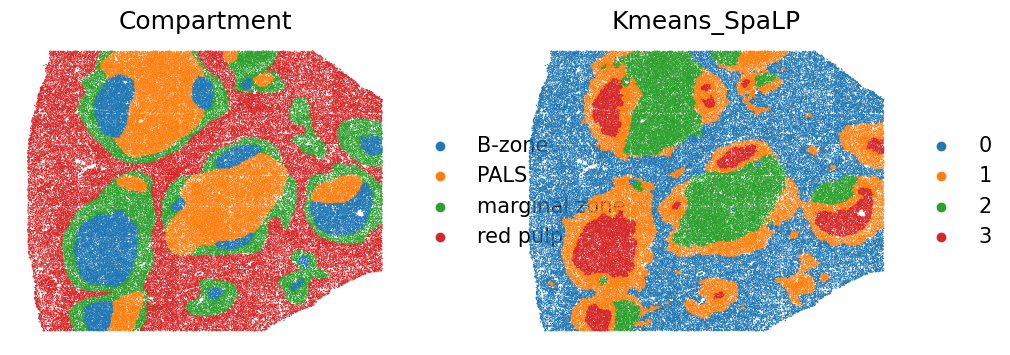

In [33]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata,basis='spatial',color=['Compartment','Kmeans_SpaLP'],frameon=False,size=4)

In [34]:
metrics = evaluate_clustering(adata, pred_key='Kmeans_SpaLP', true_key='Compartment')

  ARI: 0.6524
  NMI: 0.6190
  AMI: 0.6190
  FMI: 0.7555
  V-Measure: 0.6190
  Homogeneity: 0.6090


In [35]:
adata.write_h5ad('/home/dbj/SpaLP/gittest/repoduced/result/Ex3BALBc-2.h5ad',compression='gzip')#Save the embedding for rapid single-cell (GPU-scanpy) analysis

# BALBc-3 CODEX Mouse spleen data

In [36]:
adata=sc.read_h5ad('/home/dbj/SpaLA/Batch/CODEX/BALBc-3.h5ad')
adata.var_names_make_unique()
print(f"Shape: {adata.shape[0]:,} cells x {adata.shape[1]:,} proteins")
print(f"obsm keys: {list(adata.obsm.keys())}")

Shape: 80,636 cells x 30 proteins
obsm keys: ['spatial']


In [37]:
# Preprocessing standardization  *******
start_time = time.time()
sc.pp.scale(adata)
adata.obsm['feat']=adata.X
prep_time = time.time() - start_time

print(f"Spatial coords shape: {adata.obsm['spatial'].shape}")
print(f"Preprocessing standardization: {prep_time:.2f}s")

Spatial coords shape: (80636, 2)
Preprocessing standardization: 0.02s


In [38]:
# Set the hyperparameters  k=50
k=50
in_channels = adata.obsm['feat'].shape[1]
lr=0.001
epochs = 200
hidden_dim=32
print(f"Feature dimensions: {in_channels}")

Feature dimensions: 30


In [39]:
# Build neighbor graph  k=50
start_time = time.time()
graph = prepare_inputs(adata, k=k,device=device)
prep_time = time.time() - start_time
print(f"Graph preparation: {prep_time:.2f}s")

Graph preparation: 0.08s


In [40]:
%%time
#runtime /GPU peak memory/CPU peak memory
start_time = time.time()
@measure_resources
def run_train():
    return train_spalp(graph, in_channels, hidden_dim, epochs, lr, device, seed=7)#The default random seed for the SpaLP algorithm is 7.
embedding, losses = run_train()
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f}s")

# Store embeddings
adata.obsm['SpaLP'] = embedding

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:12<00:00, 16.38it/s, Epoch=199, Loss=0.8294]


CPU peak memory: 0.00 GB
GPU peak memory: 7.64 GB
Training time: 13.64s
CPU times: user 12.4 s, sys: 227 ms, total: 12.7 s
Wall time: 13.6 s


In [41]:
%%time
# Clustering and UMAP
start_time = time.time()
sc.pp.neighbors(adata, use_rep="SpaLP")
sc.tl.leiden(adata, resolution=0.2, random_state=2024, key_added="SpaLP")#The clustering results save in adata.obs['SpaLP']
elapsed = time.time() - start_time
print(f"Leiden time: {int(elapsed//60)}min {elapsed%60:.2f}s")

t0 = time.time()
sc.tl.umap(adata)
elapsed = time.time() - t0
print(f"UMAP time: {int(elapsed//60)}min {elapsed%60:.2f}s")
print(f"Found {len(adata.obs['SpaLP'].unique())} clusters")

Leiden time: 1min 44.27s
UMAP time: 0min 32.63s
Found 42 clusters
CPU times: user 5min 16s, sys: 4min 11s, total: 9min 28s
Wall time: 2min 16s


In [42]:
%%time
# KMeans time
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=2024) 
labels = kmeans.fit_predict(adata.obsm['SpaLP'])
adata.obs['Kmeans_SpaLP']=labels.astype(str)  #The clustering results save in adata.obs['Kmeans_SpaLP']

CPU times: user 5.94 s, sys: 4.25 s, total: 10.2 s
Wall time: 197 ms


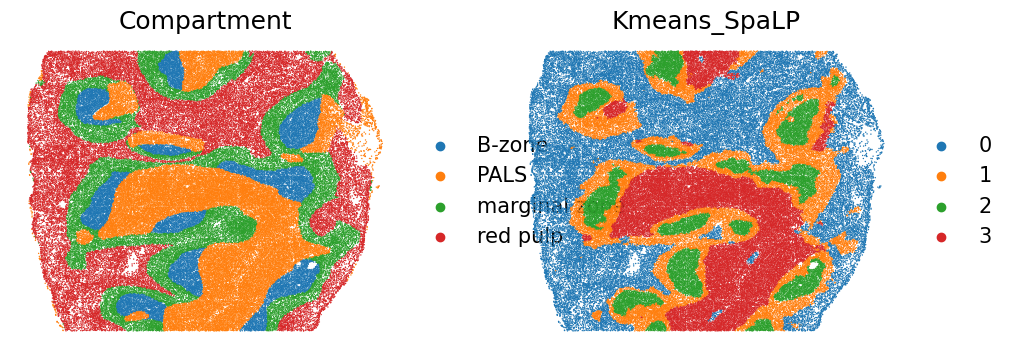

In [43]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata,basis='spatial',color=['Compartment','Kmeans_SpaLP'],frameon=False,size=4)

In [44]:
metrics = evaluate_clustering(adata, pred_key='Kmeans_SpaLP', true_key='Compartment')

  ARI: 0.5601
  NMI: 0.5577
  AMI: 0.5577
  FMI: 0.6773
  V-Measure: 0.5577
  Homogeneity: 0.5554


In [45]:
adata.write_h5ad('/home/dbj/SpaLP/gittest/repoduced/result/Ex3BALBc-3.h5ad',compression='gzip')#Save the embedding for rapid single-cell (GPU-scanpy) analysis